### Jester Jokes Recommender 

By Susan Qu

#### DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project
#### Requirements 

For the final project, you will identify an Unsupervised Learning problem to perform EDA and model analysis.  The project has 140 total points. In the instructions is a summary of the criteria you will use to guide your submission and review others’ submissions.   You will submit three deliverables:

Deliverable 1 — A Jupyter notebook showing an Unsupervised Learning problem description, EDA procedure, analysis (model building and training), result, and discussion/conclusion. 

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead. 

If your project doesn't fit into Jupyter notebook format, write your approach as a report and submit it in a pdf form.

Deliverable 2 — A video presentation or demo of your work. The presentation should be a condensed version as if you're doing a short pitch to advertise your work, so please focus on the highlights: 

What problem do you solve? 

What ML approach do you use, or what methods does your app use? 

Show the result or run an app demo. 

The minimum video length is 5 min, the maximum length is 15 min. The recommended length is about 10 min. Submit the video in .mp4 format.

Deliverable 3 — A public project GitHub repository with your work (please also include the GitHub repo URL in your notebook/report and slides). 



#### Problem Description

Business Scenario: we have more than 36K users subscribed to our online joke service, each day we want to send a new joke to the user via email, that he hasn't rated before. In this project, we are looking to find the most suitable algorithm to find and recommend the relevant jokes to users. 

#### Data Gahtering

The original Jester jokes dataset was made available by Ken Goldberg at UC Berkeley AUTOLab, for the Eigentaste: A Constant Time Collaborative Filtering Algorithm. The first dataset (Dataset 1) had 4.1 million ratings, values from (-10.00 to +10.00) of 100 jokes from 73,421 users: collected between April 1999 - May 2003. We will be using a subset of the data for the current project. 


#### Dataset Description 

This dataset is downloaded from Kaggle, https://www.kaggle.com/datasets/aakaashjois/jester-collaborative-filtering-dataset:
- The complete dataset is split into 3 .csv files.
- JokeText.csv contains the Id of the joke and the complete joke string.
- UserRatings1.csv contains the ratings provided by the first 36710 users.
- The dataset is arranged such that the initial users have rated higher number of jokes than the later users.
- The rating is a real value between -10.0 and +10.0.
- The empty values indicate that the user has not provided any rating for that particular joke.

#### Modeling Approach

Since there are no categorical data for each joke, to establish item-item similarity, we will use topic modeling method via NMF to extract topics from each joke, and create cosine simlarity matrix based on the topics to find jokes that are similar to each other. 

This content based similarity matrix will then be used in the recommendatation system, to recommend our users the similar jokes if user hasn't rated this joke already. 

Another recommender systerm we explore here is the user-user similarity collaboritve filtering approach, where we establish similarity matrix based on similar users' ratings of jokes in query.  

To evaluate the performance of each model, we will split the dataset, into train and test set. Since not all user have  We will reserve 20% of rated jokes from each user as test set. We'll establish baseilne by using the user's average rating and use RMSE as the metric to evaluate the models. 

#### Steps

- EDA
- Topic Modelling via Unsupervised Algo (NMF)
    - Joke text embedding vectorization
    - Establish item to item similarity based on n topics 
- Recommender
    - Split the current user data into train and test
    - Baseline approach
    - Content similary approach 
    - Collaborative filtering approach
    - Apply Predict function to compare the approaches 

In [263]:
# Library Import

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import regex as re
import time

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#### Data Import and EDA

In [7]:
jokes_df = pd.read_csv('data/JokeText.csv')
user_ratings_df = pd.read_csv('data/UserRatings1.csv')

In [8]:
jokes_df.head(2)

,JokeId,JokeText
0,0,"A man visits the doctor. The doctor says ""I ha..."
1,1,This couple had an excellent relationship goin...


In [10]:
user_ratings_df.head(2)

,JokeId,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User36701,User36702,User36703,User36704,User36705,User36706,User36707,User36708,User36709,User36710
0,0,5.1,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.91,NaN
1,1,4.9,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,...,NaN,NaN,NaN,-5.63,NaN,-6.07,NaN,-1.6,-4.56,NaN


#### Data Processing 
- reformat User Ratings df to be long instead of wide

In [12]:
# Convert from wide format to long format
ratings_long_df = pd.melt(user_ratings_df, 
                          id_vars=['JokeId'], 
                          var_name='UserID', 
                          value_name='Rating')

# Drop rows with NaN ratings
ratings_long_df = ratings_long_df.dropna(subset=['Rating'])

# Display the first few rows
print(f"Total number of ratings: {len(ratings_long_df)}")
ratings_long_df.head()

Total number of ratings: 3012090


,JokeId,UserID,Rating
0,0,User1,5.10
1,1,User1,4.90
2,2,User1,1.75
3,3,User1,-4.17
4,4,User1,5.15


In [253]:
ratings_long_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3012090 entries, 0 to 3670984
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   JokeId  int64  
 1   UserID  object 
 2   Rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 156.4+ MB


In [21]:
# Group by JokeId and sum all ratings
joke_popularity = ratings_long_df.groupby('JokeId')['Rating'].agg(['sum', 'count', 'mean']).reset_index()

# Sort by sum of ratings in descending order
joke_popularity_by_sum = joke_popularity.sort_values(by='sum', ascending=False)

# Join with jokes_df to get the joke text
popular_jokes = joke_popularity_by_sum.merge(jokes_df, on='JokeId')

# Display the top 10 most popular jokes by total sum of ratings
top_10_popular_jokes = popular_jokes.head(10)
print("Top 10 Most Popular Jokes (by sum of ratings):")
display(top_10_popular_jokes[['JokeId', 'sum', 'count', 'mean', 'JokeText']])

# Find the most rated jokes (by count)
joke_popularity_by_count = joke_popularity.sort_values(by='count', ascending=False)
most_rated_jokes = joke_popularity_by_count.merge(jokes_df, on='JokeId')

# Display the top 10 most rated jokes
top_10_most_rated_jokes = most_rated_jokes.head(10)
print("\nTop 10 Most Rated Jokes (by number of ratings):")
display(top_10_most_rated_jokes[['JokeId', 'count', 'sum', 'mean', 'JokeText']])


Top 10 Most Popular Jokes (by sum of ratings):


,JokeId,sum,count,mean,JokeText
0,49,133031.16,36705,3.624333,A guy goes into confession and says to the pri...
1,35,116680.13,36704,3.178949,"A guy walks into a bar, orders a beer and says..."
2,31,115469.78,36704,3.145973,A man arrives at the gates of heaven. St. Pete...
3,26,114260.95,36701,3.113293,Clinton returns from a vacation in Arkansas an...
4,34,111564.68,36705,3.039495,An explorer in the deepest Amazon suddenly fin...
5,61,106739.37,36704,2.908113,A group of managers were given the assignment...
6,28,106662.91,36703,2.906109,An old Scotsmen is sitting with a younger Scot...
7,52,101805.99,36706,2.773552,One Sunday morning William burst into the livi...
8,48,98963.06,36705,2.696174,Three engineering students were gathered toget...
9,53,97260.42,36691,2.650798,"The Pope dies and, naturally, goes to heaven. ..."



Top 10 Most Rated Jokes (by number of ratings):


,JokeId,count,sum,mean,JokeText
0,16,36710,-40400.60,-1.100534,How many men does it take to screw in a light ...
1,7,36708,-20763.65,-0.565644,Q. Did you hear about the dyslexic devil worsh...
2,12,36708,-62137.72,-1.692757,They asked the Japanese visitor if they have e...
3,14,36707,-68530.59,-1.866962,Q: What did the blind person say when given s...
4,6,36707,-14773.84,-0.402480,How many feminists does it take to screw in a ...
5,68,36707,91674.78,2.497474,"This guys wife asks, ""Honey if I died would yo..."
6,60,36706,82448.88,2.246196,"During a recent publicity outing, Hillary snea..."
7,64,36706,80173.00,2.184193,Two Rednecks were seated at the end of a bar w...
8,19,36706,-38035.83,-1.036229,What's the difference between a MacIntosh and ...
9,52,36706,101805.99,2.773552,One Sunday morning William burst into the livi...


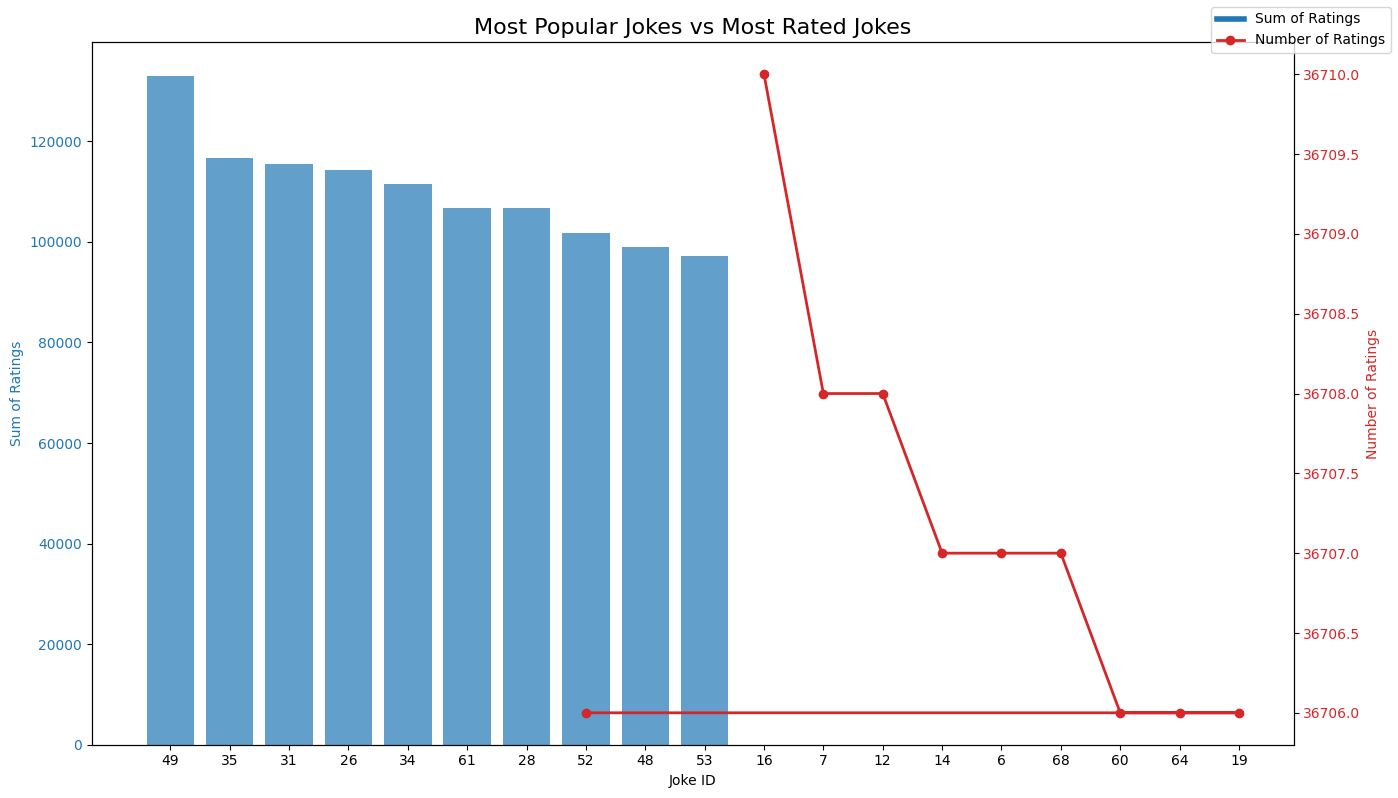

In [ ]:
# display the top 10 most rated jokes and the top 10 most popular jokes in a single plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the most popular jokes by sum of ratings (bars)
color = 'tab:blue'
ax1.set_xlabel('Joke ID')
ax1.set_ylabel('Sum of Ratings', color=color)
bars = ax1.bar(top_10_popular_jokes['JokeId'].astype(str), top_10_popular_jokes['sum'], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for number of ratings
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Ratings', color=color)
bar = ax2.plot(top_10_most_rated_jokes['JokeId'].astype(str), top_10_most_rated_jokes['count'], color=color, marker='o', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and adjust layout
plt.title('Most Popular Jokes vs Most Rated Jokes', fontsize=16)
plt.tight_layout()

# Add a legend
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Sum of Ratings'),
                  Line2D([0], [0], color='tab:red', marker='o', lw=2, label='Number of Ratings')]
fig.legend(handles=legend_elements, loc='upper right')

plt.show()

#### Note
The most popular jokes might not be the most rated jokes

#### Check the distribution of ratings

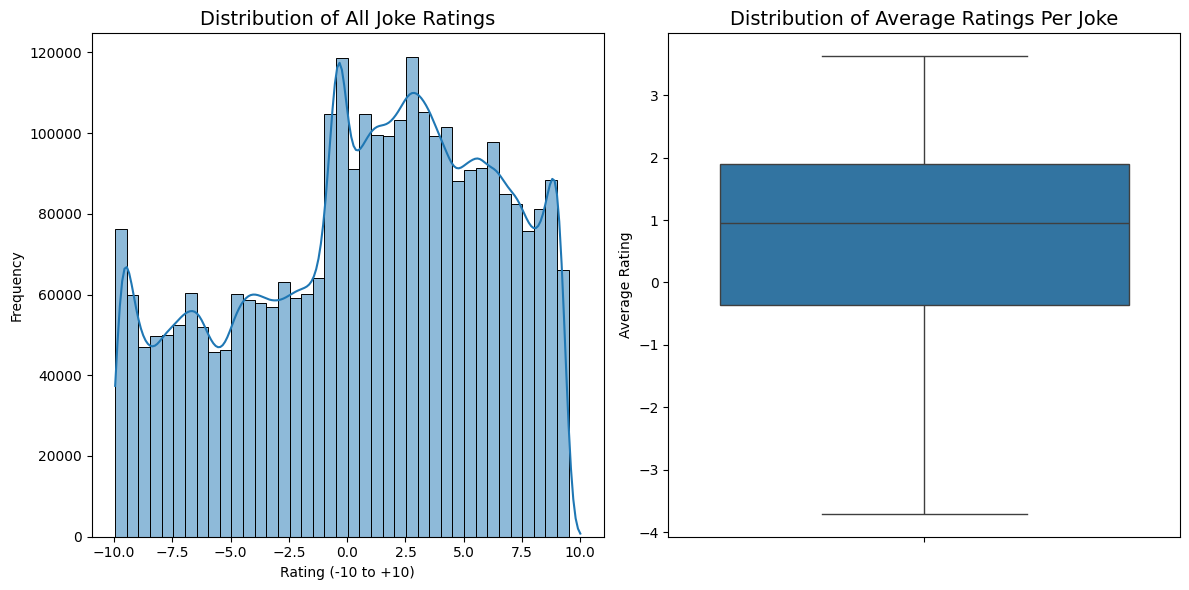

Top 5 highest rated jokes:


,JokeId,mean,count,JokeText
0,49,3.624333,36705,A guy goes into confession and says to the pri...
1,88,3.573825,17814,A radio conversation of a US naval \nship with...
2,35,3.178949,36704,"A guy walks into a bar, orders a beer and says..."
3,31,3.145973,36704,A man arrives at the gates of heaven. St. Pete...
4,26,3.113293,36701,Clinton returns from a vacation in Arkansas an...



Bottom 5 lowest rated jokes:


,JokeId,mean,count,JokeText
0,57,-3.706917,29486,How many teddybears does it take to change a l...
1,15,-2.956270,36703,Q. What is orange and sounds like a parrot? \...
2,43,-2.003736,30684,"A horse walks into a bar. Bartender says:\n""So..."
3,56,-1.894317,30280,Why are there so many Jones's in the phone boo...
4,14,-1.866962,36707,Q: What did the blind person say when given s...


In [22]:
# Plot the overall distribution of ratings
plt.figure(figsize=(12, 6))

# Histogram of all ratings
plt.subplot(1, 2, 1)
sns.histplot(ratings_long_df['Rating'], bins=40, kde=True)
plt.title('Distribution of All Joke Ratings', fontsize=14)
plt.xlabel('Rating (-10 to +10)')
plt.ylabel('Frequency')

# Box plot for average ratings per joke
plt.subplot(1, 2, 2)
joke_avg_ratings = ratings_long_df.groupby('JokeId')['Rating'].mean().reset_index()
sns.boxplot(y=joke_avg_ratings['Rating'])
plt.title('Distribution of Average Ratings Per Joke', fontsize=14)
plt.ylabel('Average Rating')

plt.tight_layout()
plt.show()

# Let's also look at the top vs bottom rated jokes
top_5_jokes = joke_popularity.sort_values(by='mean', ascending=False).head(5)
bottom_5_jokes = joke_popularity.sort_values(by='mean', ascending=True).head(5)

# Combine with joke text
top_5_with_text = top_5_jokes.merge(jokes_df, on='JokeId')
bottom_5_with_text = bottom_5_jokes.merge(jokes_df, on='JokeId')

print("Top 5 highest rated jokes:")
display(top_5_with_text[['JokeId', 'mean', 'count', 'JokeText']])

print("\nBottom 5 lowest rated jokes:")
display(bottom_5_with_text[['JokeId', 'mean', 'count', 'JokeText']])

#### Note
- More jokes are rated positively than negatively, looks to be 50% more by looking at the histogram. Large concentration of rating are between 1-6. 
- Half of the jokes are rated 1 and above, half are rated 1 and below. 

#### Let's check the Distribution of Numbers of Ratings per user

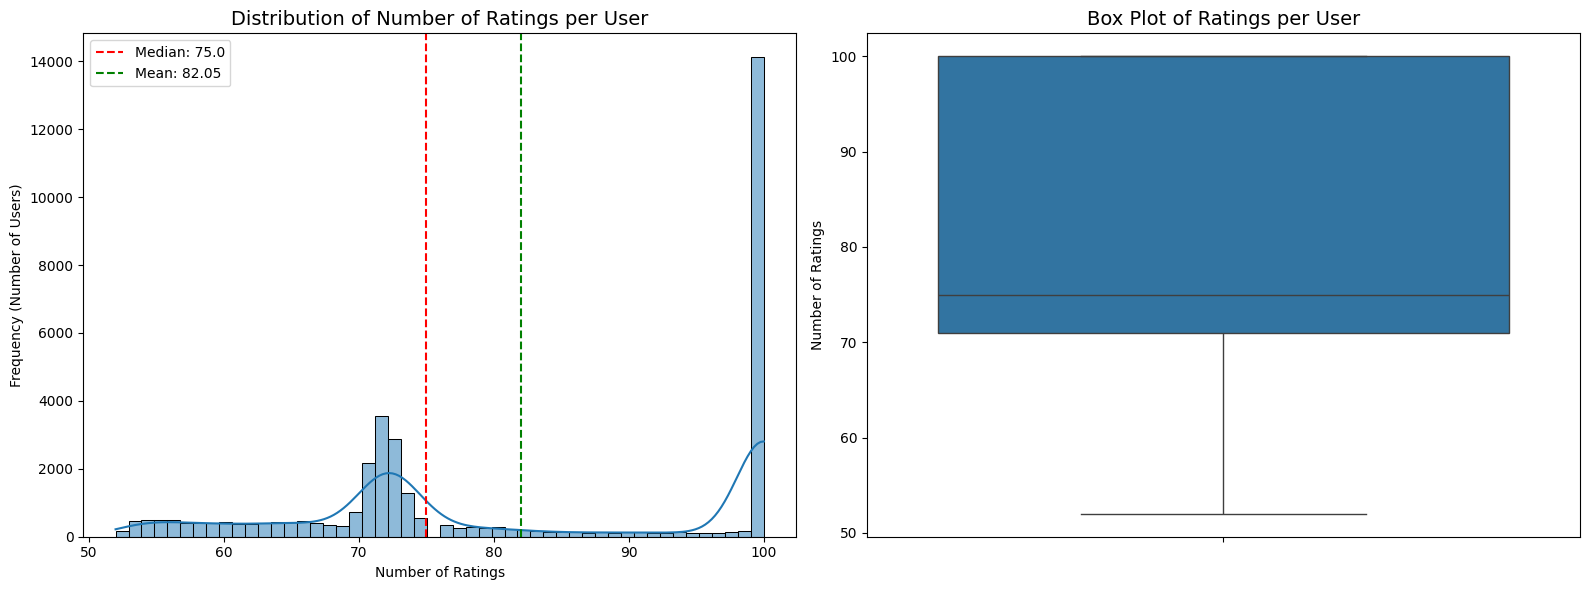

Total number of users: 36710
Average num of ratings per user: 82.05
Median num of ratings per user: 75.0
Min num of ratings ratings per user: 52
Max num of ratings per user: 100

Percentiles:
25th percentile: 71.0
75th percentile: 100.0
90th percentile: 100.0
95th percentile: 100.0


In [24]:
# Count the number of ratings per user
ratings_per_user = ratings_long_df.groupby('UserID').size()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram on the left
sns.histplot(ratings_per_user, bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Number of Ratings per User', fontsize=14)
ax1.set_xlabel('Number of Ratings')
ax1.set_ylabel('Frequency (Number of Users)')
ax1.axvline(ratings_per_user.median(), color='red', linestyle='--', label=f'Median: {ratings_per_user.median()}')
ax1.axvline(ratings_per_user.mean(), color='green', linestyle='--', label=f'Mean: {ratings_per_user.mean():.2f}')
ax1.legend()

# Box plot on the right
sns.boxplot(y=ratings_per_user, ax=ax2)
ax2.set_title('Box Plot of Ratings per User', fontsize=14)
ax2.set_ylabel('Number of Ratings')

plt.tight_layout()
plt.show()

# Display statistics
print(f"Total number of users: {len(ratings_per_user)}")
print(f"Average num of ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median num of ratings per user: {ratings_per_user.median()}")
print(f"Min num of ratings ratings per user: {ratings_per_user.min()}")
print(f"Max num of ratings per user: {ratings_per_user.max()}")
print("\nPercentiles:")
print(f"25th percentile: {ratings_per_user.quantile(0.25)}")
print(f"75th percentile: {ratings_per_user.quantile(0.75)}")
print(f"90th percentile: {ratings_per_user.quantile(0.90)}")
print(f"95th percentile: {ratings_per_user.quantile(0.95)}")

#### Create a Train and Test Set 
- Since the avg number of ratings per user is 82 jokes, we have 100 jokes in total, let's randomly select 20% of the ratings per user as the test set. 

In [30]:
# Set random seed for reproducibility
np.random.seed(42)

# Group the data by UserID
grouped = ratings_long_df.groupby('UserID')

# Create lists to store indices
train_indices = []
test_indices = []

# For each user, randomly split their ratings
for user_id, user_ratings in grouped:
    # Get indices of this user's ratings
    indices = user_ratings.index.tolist()
    
    # Split the indices
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    # Add to our lists
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Create train and test DataFrames
train_user_rating_df = ratings_long_df.loc[train_indices]
test_user_rating_df = ratings_long_df.loc[test_indices]

# Print the shapes to verify
print(f"Original data shape: {ratings_long_df.shape}")
print(f"Training data shape: {train_user_rating_df.shape}")
print(f"Testing data shape: {test_user_rating_df.shape}")
print(f"Percentage in test: {len(test_user_rating_df) / len(ratings_long_df):.2%}")

Original data shape: (3012090, 3)
Training data shape: (2399789, 3)
Testing data shape: (612301, 3)
Percentage in test: 20.33%


In [36]:
# Let's check userId User36704, number of ratings in the original data
print(f"User36704 ratings in original data: {len(ratings_long_df[ratings_long_df['UserID'] == 'User36704'])}")

User36704 ratings in original data: 52


In [38]:
# Let's check userId User36704, number of ratings in the train data
print(f"User36704 ratings in train data: {len(train_user_rating_df[train_user_rating_df['UserID'] == 'User36704'])}")

User36704 ratings in train data: 41


In [39]:
# Let's check userId User36704, number of ratings in the test data
print(f"User36704 ratings in test data: {len(test_user_rating_df[test_user_rating_df['UserID'] == 'User36704'])}")

User36704 ratings in test data: 11


#### Note
Okay, the train and test set looks good! 

#### Let's do Topic Modeling for Jokes via NMF 

##### Word Vectorization via TfidfVectorizer

In [40]:
# clean text
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

[nltk_data] Downloading package wordnet to /Users/squ/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/squ/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/squ/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
jokes_df['text_cleaned'] = jokes_df['JokeText'].apply(clean_text)

In [291]:
jokes_df.head(2)

,JokeId,JokeText,text_cleaned,word_count
0,0,"A man visits the doctor. The doctor says ""I ha...",man visit doctor doctor say bad news youyou ca...,17
1,1,This couple had an excellent relationship goin...,couple excellent relationship going one day ca...,33


##### Check the word count for all the jokes in cleaned text

In [51]:
# check the word count for all the jokes
jokes_df['word_count'] = jokes_df['text_cleaned'].apply(lambda x: len(x.split()))

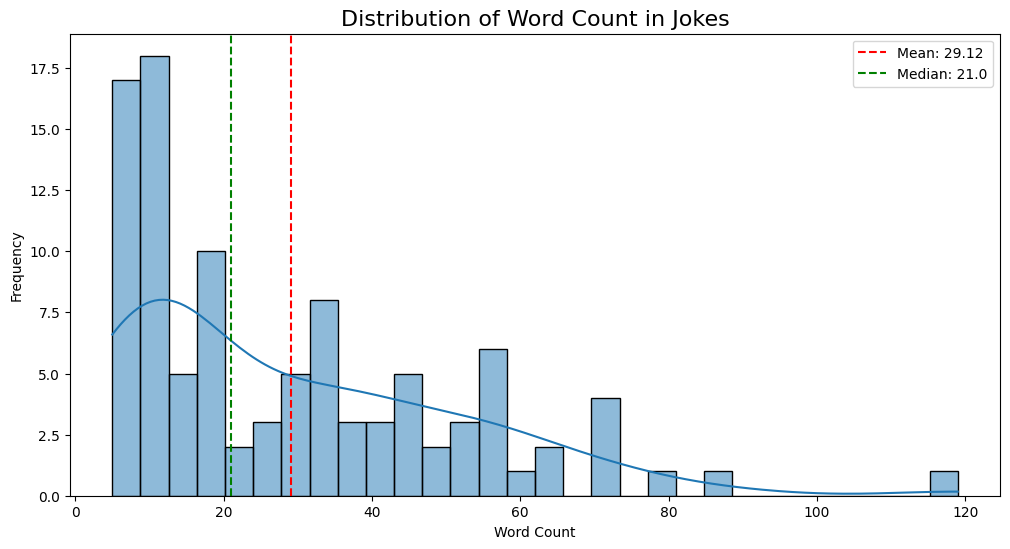

In [52]:
# plot the distribution of word count
plt.figure(figsize=(12, 6))
sns.histplot(jokes_df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Jokes', fontsize=16)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(jokes_df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {jokes_df["word_count"].mean():.2f}')
plt.axvline(jokes_df['word_count'].median(), color='green', linestyle='--', label=f'Median: {jokes_df["word_count"].median()}')
plt.legend()
plt.show()

#### Note
- The avg joke has 29 words. 
- The longest joke has about 118 words. 
- We only to use 119 as the `max_features` in the vectoriztion 

In [53]:
# Preprocess and vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=119)
tfidf = vectorizer.fit_transform(jokes_df['text_cleaned'])

In [54]:
# Visualize the TF-IDF matrix structure
print(f"TF-IDF Matrix Shape: {tfidf.shape}")  # (n_documents, n_features)
print(f"Total Elements: {tfidf.shape[0] * tfidf.shape[1]}")
print(f"Non-zero Elements: {tfidf.nnz}")
print(f"Sparsity: {100.0 * (1 - tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])):.2f}%")

TF-IDF Matrix Shape: (100, 119)
Total Elements: 11900
Non-zero Elements: 590
Sparsity: 95.04%


#### The word embedding is quite sparse, let's visualize the first 10 joke and random 40 words 

first 2 jokes of the subset_matrix:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.26027145 0.         0.         0.
  0.         0.         0.         0.43715819 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.22063457 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.24247386 0.         0.        ]]


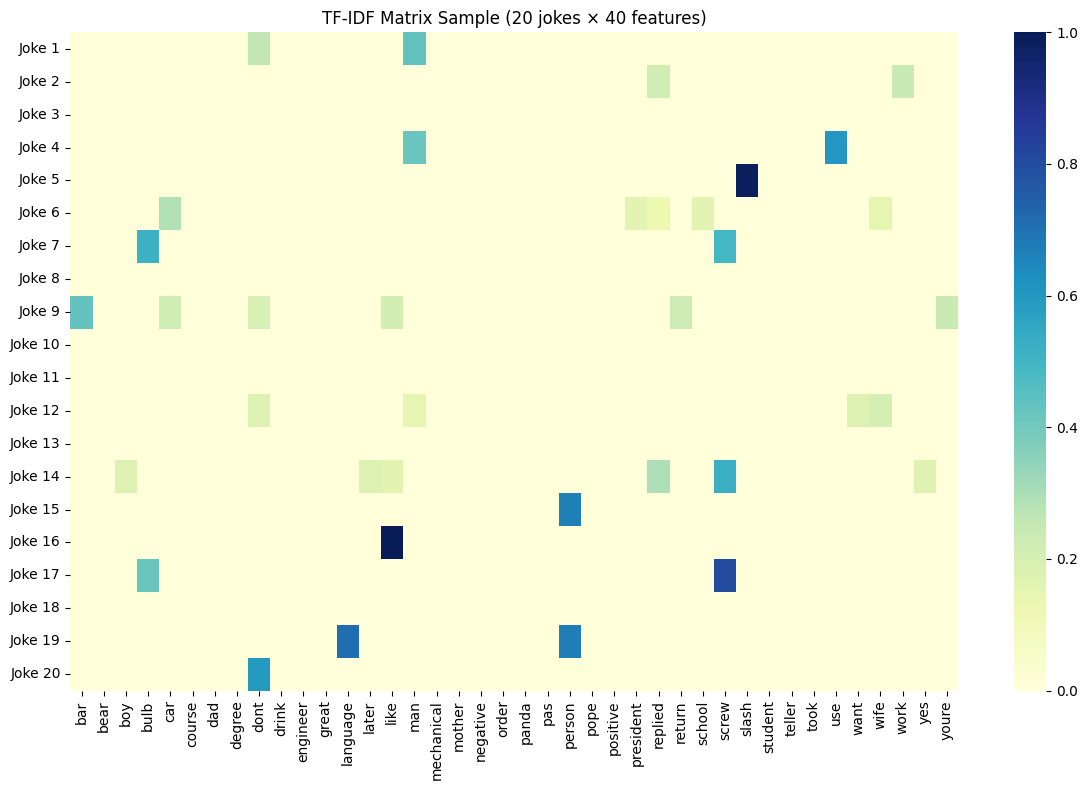

In [55]:
# Select a subset (first 10 jokes, random 40 words)
subset_docs = 20
random_features = np.random.choice(tfidf.shape[1], 40, replace=False)
random_features.sort()

# Extract dense subset for visualization
subset_matrix = tfidf[:subset_docs, random_features].toarray()
print('first 2 jokes of the subset_matrix:')
print(subset_matrix[:2, :])

# Get feature names for these columns
feature_names = vectorizer.get_feature_names_out()[random_features]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(subset_matrix, cmap='YlGnBu', 
            xticklabels=[f[:10] for f in feature_names],  # Truncate long words
            yticklabels=[f"Joke {i+1}" for i in range(subset_docs)])
plt.title('TF-IDF Matrix Sample (20 jokes × 40 features)')
plt.tight_layout()
plt.show()

##### Apply NMF to Matrix
- Since there are only 100 jokes, let's try 10 topics

In [300]:
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(tfidf)  # Document-topic matrix
H = nmf.components_            # Topic-word matrix

In [301]:
print("Joke-topic matrix shape:", W.shape)
print("Topic-word matrix shape:", H.shape)


Joke-topic matrix shape: (100, 10)
Topic-word matrix shape: (10, 119)


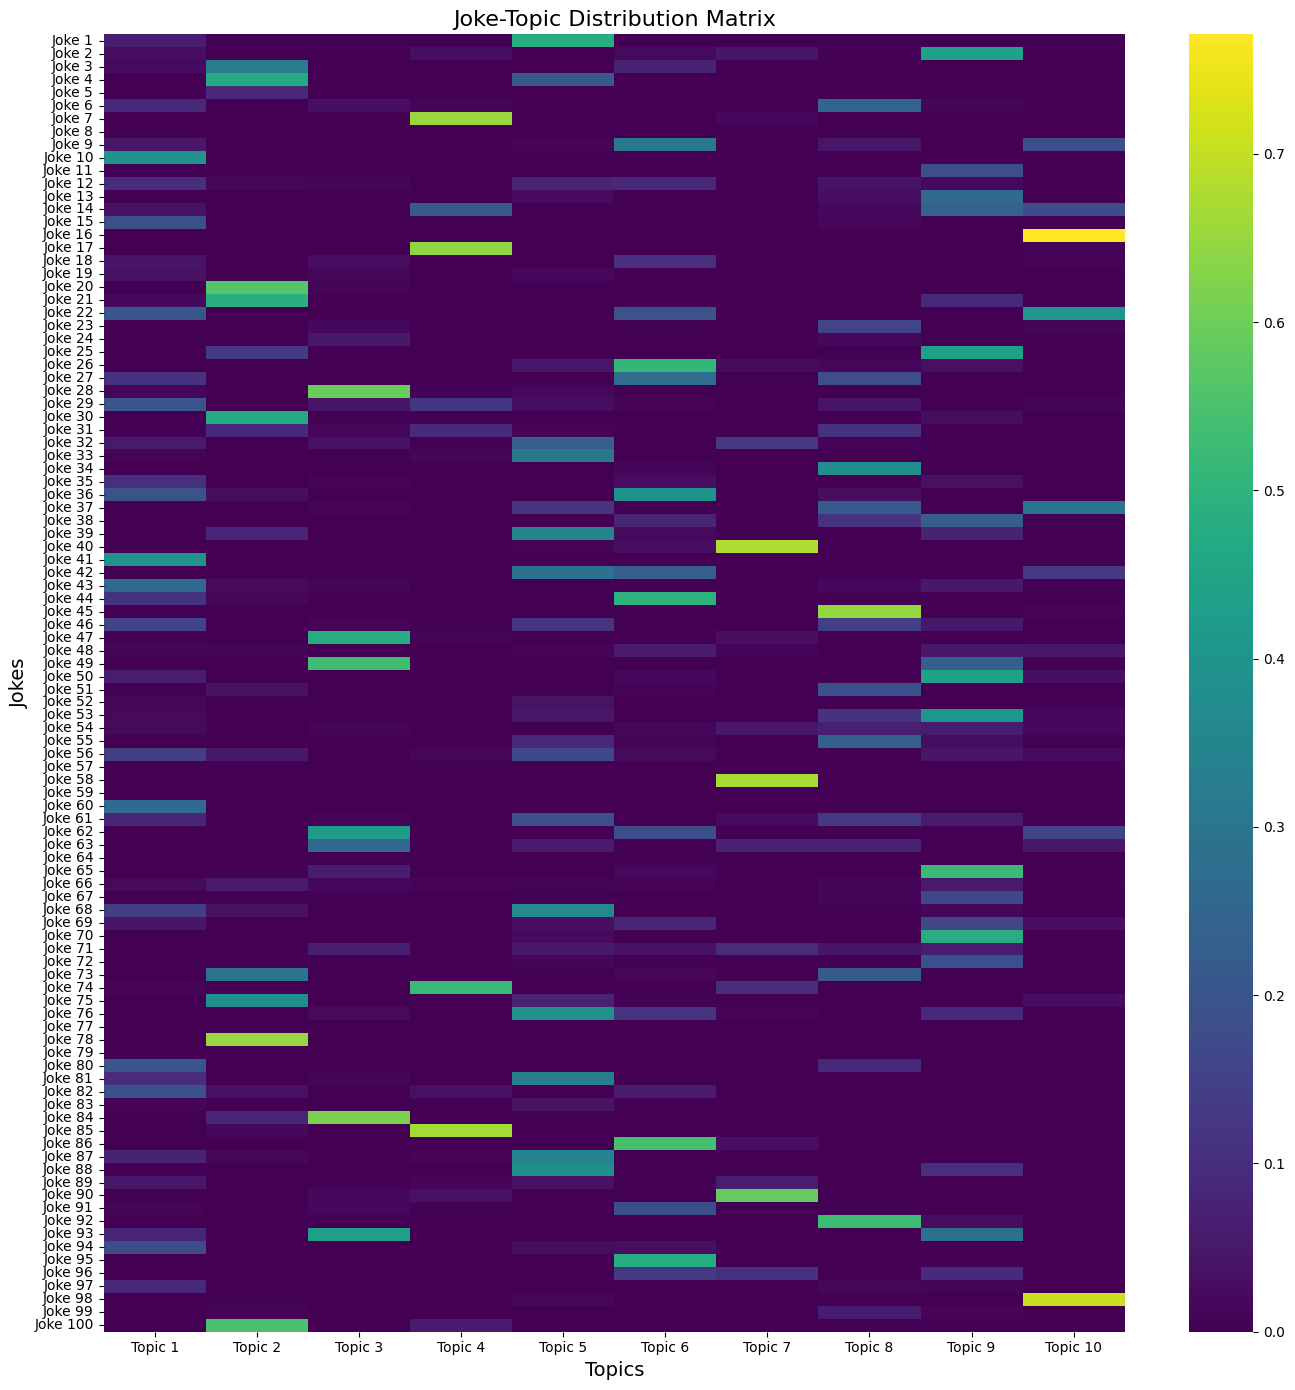

In [303]:
# Create a heatmap of the entire W matrix
plt.figure(figsize=(14, 14))
sns.heatmap(W, cmap='viridis', 
            xticklabels=[f"Topic {i+1}" for i in range(W.shape[1])],
            yticklabels=[f"Joke {i+1}" for i in range(W.shape[0])])
plt.title('Joke-Topic Distribution Matrix', fontsize=16)
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Jokes', fontsize=14)
plt.tight_layout()
plt.show()

In [93]:
print("Joke-topic matrix example first document:", W[0:1])
print("Joke-topic matrix example second document:", W[1:2])
print("First 10 words in the topic-word H matrix:", [vectorizer.get_feature_names_out()[i] for i in H[0].argsort()[-10:]])
print("First 10 words in the topic-word H matrix:", H[0][: 10])

Joke-topic matrix example first document: [[0.05804083 0.         0.         0.         0.47631282 0.
  0.         0.         0.         0.        ]]
Joke-topic matrix example second document: [[0.0251655  0.         0.         0.0255114  0.         0.01968934
  0.04438988 0.00383603 0.43667292 0.        ]]
First 10 words in the topic-word H matrix: ['ill', 'positive', 'great', 'long', 'hell', 'hillary', 'day', 'person', 'make', 'say']
First 10 words in the topic-word H matrix: [0.         0.00211121 0.         0.0964648  0.         0.
 0.01448114 0.         0.15058831 0.00186202]


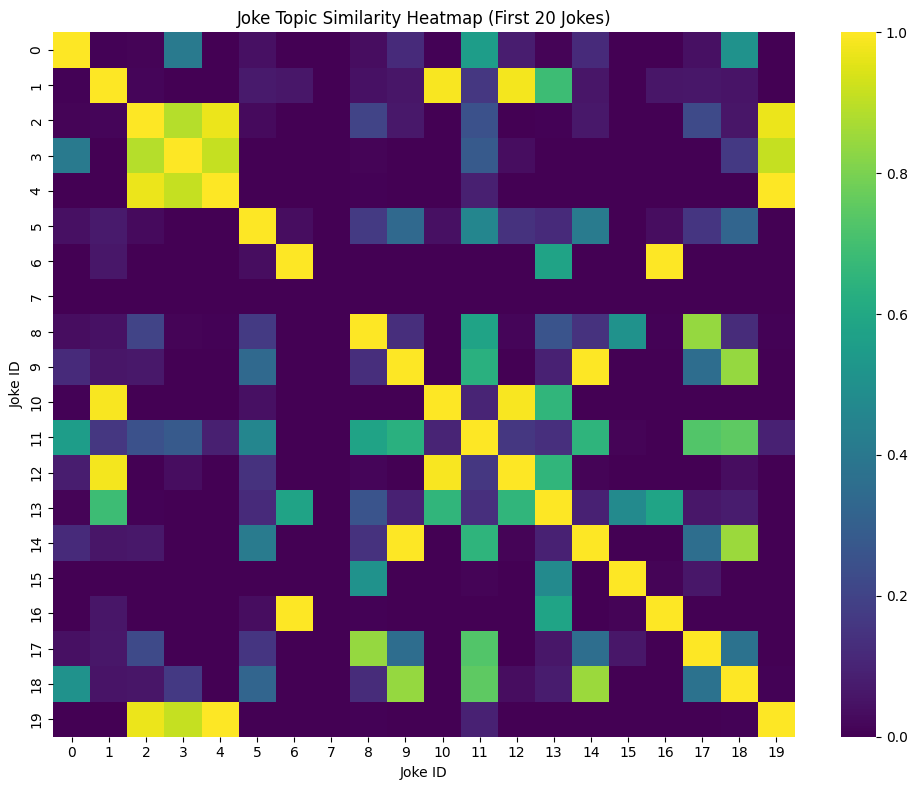

In [ ]:
# Calculate pairwise cosine similarities between all jokes based on topic distribution
joke_similarities = cosine_similarity(W)

# Function to get top N similar jokes for a given joke
def find_similar_jokes(joke_id, n=5):
    """
    Returns the top N jokes most similar to the given joke_id based on topic distribution.
    
    Parameters:
    joke_id (int): The JokeId value
    n (int): Number of similar jokes to return
    
    Returns:
    DataFrame: A dataframe with similar jokes and their similarity scores
    """
    # Get the similarities for this joke (excluding itself)
    sim_scores = joke_similarities[joke_id]
    
    # Create a dataframe with joke_id and similarity score
    scores_df = pd.DataFrame({
        'JokeId': range(len(sim_scores)),
        'Similarity': sim_scores
    })
    
    # Sort by similarity score in descending order and exclude the joke itself
    similar_jokes = scores_df[scores_df['JokeId'] != joke_id].sort_values(
        by='Similarity', ascending=False).head(n)
    
    # Join with the joke text
    result = similar_jokes.merge(jokes_df[['JokeId', 'JokeText']], on='JokeId')
    
    return result

# Visualize similarity as a heatmap (for a subset of jokes)
plt.figure(figsize=(10, 8))
sns.heatmap(joke_similarities[:20, :20], cmap='viridis', 
            xticklabels=range(20), yticklabels=range(20))
plt.title('Joke Topic Similarity Heatmap (First 20 Jokes)')
plt.xlabel('Joke ID')
plt.ylabel('Joke ID')
plt.tight_layout()
plt.show()

In [85]:
# let's check joke 16 and joke 6
print("Joke 16 text:", jokes_df['JokeText'].iloc[6])
print("Joke 6 text:", jokes_df['JokeText'].iloc[16])

Joke 16 text: How many feminists does it take to screw in a light bulb?
That's not funny.

Joke 6 text: How many men does it take to screw in a light bulb? 

One...men will screw anything. 



In [304]:
# let's check joke 19 and joke 4
print("Joke 19 text:", jokes_df['JokeText'].iloc[9])
print("Joke 4 text:", jokes_df['JokeText'].iloc[14])

Joke 19 text: Two cannibals are eating a clown, one turns to other and says: 
"Does this taste funny to you? 

Joke 4 text: Q:  What did the blind person say when given some matzah?

A:  Who the hell wrote this?



In [115]:
# let's check joke 19 and joke 2
print("Joke 19 text:", jokes_df['JokeText'].iloc[19])
print("Joke 2 text:", jokes_df['JokeText'].iloc[2])

Joke 19 text: What's the difference between a MacIntosh and an
Etch-A-Sketch? 

You don't have to shake the Mac to clear the screen. 

Joke 2 text: Q. What's 200 feet long and has 4 teeth? 

A. The front row at a Willie Nelson Concert.



In [96]:
def compare_joke_similarities(tfidf_matrix, jokes_df, n_topics=10, n_jokes_to_display=20, random_state=42):
    """
    Compare joke similarities based on NMF topic modeling with a specified number of topics.
    
    Parameters:
    -----------
    tfidf_matrix : sparse matrix
        The TF-IDF matrix of the jokes
    jokes_df : pandas.DataFrame
        DataFrame containing joke information
    n_topics : int
        Number of topics for NMF
    n_jokes_to_display : int
        Number of jokes to include in the heatmap visualization
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        (nmf_model, W_matrix, similarity_matrix, topic_words)
    """
    # Create NMF model with specified number of topics
    nmf = NMF(n_components=n_topics, random_state=random_state)
    
    # Fit the model and get document-topic and topic-word matrices
    W = nmf.fit_transform(tfidf_matrix)  # Document-topic matrix
    H = nmf.components_  # Topic-word matrix
    
    # Calculate pairwise cosine similarities
    joke_similarities = cosine_similarity(W)
    
    # Get the most important words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topic_words = {}
    for topic_idx, topic in enumerate(H):
        top_indices = topic.argsort()[:-11:-1]
        topic_words[topic_idx] = [feature_names[i] for i in top_indices]
    
    # Print topic words
    print(f"\n----- Topics with n_topics={n_topics} -----")
    for topic_idx, words in topic_words.items():
        print(f"Topic #{topic_idx}: {', '.join(words[:10])}")
    
    # Visualize similarity as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(joke_similarities[:n_jokes_to_display, :n_jokes_to_display], 
                cmap='viridis',
                xticklabels=range(n_jokes_to_display), 
                yticklabels=range(n_jokes_to_display))
    plt.title(f'Joke Topic Similarity Heatmap (First {n_jokes_to_display} Jokes)\nwith {n_topics} Topics', 
              fontsize=14)
    plt.xlabel('Joke ID')
    plt.ylabel('Joke ID')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display topic diversity metrics
    topic_diversity = np.mean(np.std(W, axis=1))
    print(f"Topic diversity (mean std of joke-topic weights): {topic_diversity:.4f}")
    
    # Calculate average similarity between jokes
    avg_similarity = (np.sum(joke_similarities) - np.trace(joke_similarities)) / (joke_similarities.shape[0] * (joke_similarities.shape[0] - 1))
    print(f"Average joke similarity: {avg_similarity:.4f}")
    
    return nmf, W, joke_similarities, topic_words


----- Topics with n_topics=10 -----
Topic #0: say, make, person, day, hillary, hell, long, great, positive, ill
Topic #1: difference, whats, president, lawyer, know, dont, great, use, long, work
Topic #2: engineer, mechanical, said, look, company, end, machine, problem, ill, car
Topic #3: bulb, light, screw, president, thats, day, change, father, beer, look
Topic #4: man, doctor, woman, news, know, teller, american, bad, room, reply
Topic #5: walk, bar, bartender, guy, drink, got, order, long, woman, asks
Topic #6: lightbulb, change, room, drink, problem, thats, told, quiet, company, pas
Topic #7: school, teacher, mother, tell, clinton, husband, come, boy, hillary, got
Topic #8: said, asked, time, girl, father, going, year, need, told, want
Topic #9: like, age, think, asks, mother, sleep, boy, wake, father, start


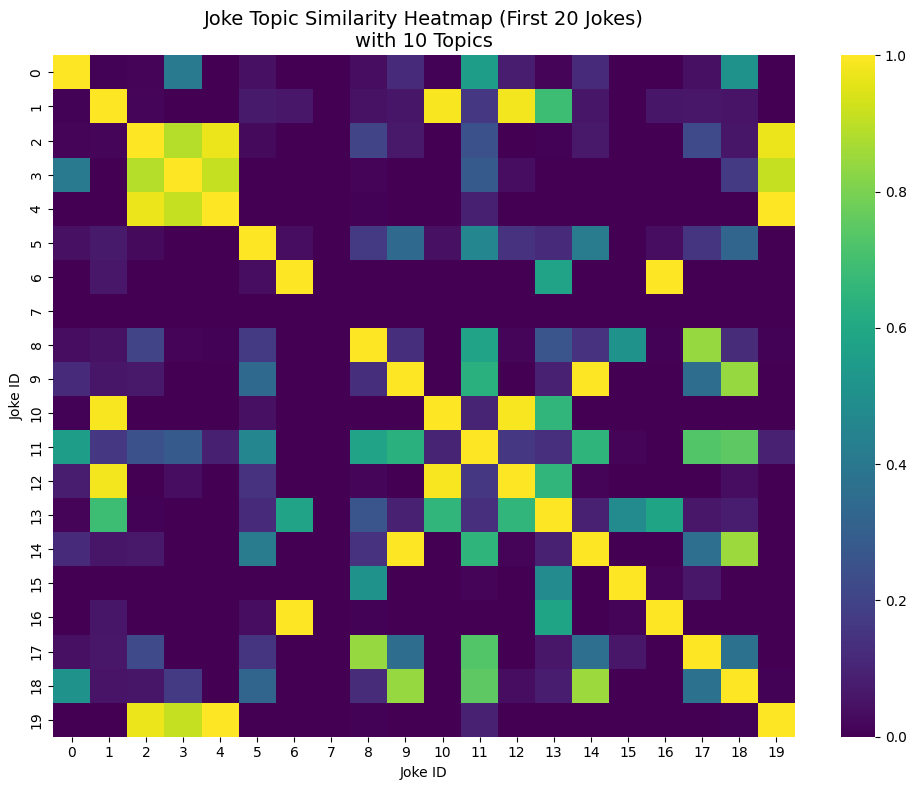

Topic diversity (mean std of joke-topic weights): 0.0959
Average joke similarity: 0.1788

----- Topics with n_topics=20 -----
Topic #0: say, great, beer, ill, voice, make, positive, youre, look, reply
Topic #1: difference, whats, dont, lawyer, use, great, know, work, year, long
Topic #2: engineer, mechanical, look, said, machine, end, company, problem, ill, car
Topic #3: bulb, light, screw, thats, change, day, father, president, boy, beer
Topic #4: woman, man, need, want, guy, car, drink, know, got, age
Topic #5: walk, bar, bartender, guy, drink, order, got, long, reply, asks
Topic #6: lightbulb, change, problem, drink, thats, room, told, day, bulb, machine
Topic #7: husband, year, later, married, ill, tell, woman, teller, wife, hillary
Topic #8: clinton, tell, know, difference, hillary, return, got, reply, dollar, pope
Topic #9: school, teacher, mother, come, boy, want, got, tell, son, dont
Topic #10: asked, going, yes, replied, theyre, order, tell, girl, told, broom
Topic #11: make, 

/Users/squ/.pyenv/versions/3.12.9/envs/devenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


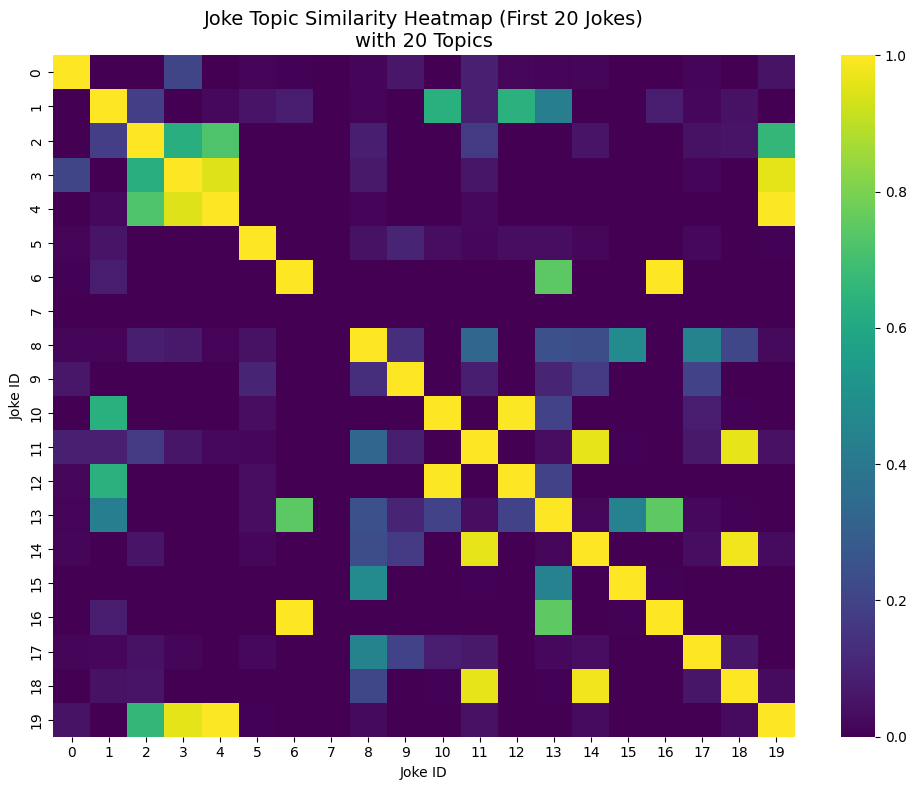

Topic diversity (mean std of joke-topic weights): 0.0790
Average joke similarity: 0.0914

----- Topics with n_topics=5 -----
Topic #0: say, walk, make, long, hillary, bar, bartender, reply, asks, great
Topic #1: difference, whats, president, know, lawyer, dont, great, use, clinton, long
Topic #2: engineer, said, mechanical, company, look, end, year, machine, problem, time
Topic #3: bulb, light, screw, thats, change, president, lightbulb, day, father, problem
Topic #4: man, woman, doctor, asked, know, news, guy, husband, drink, room


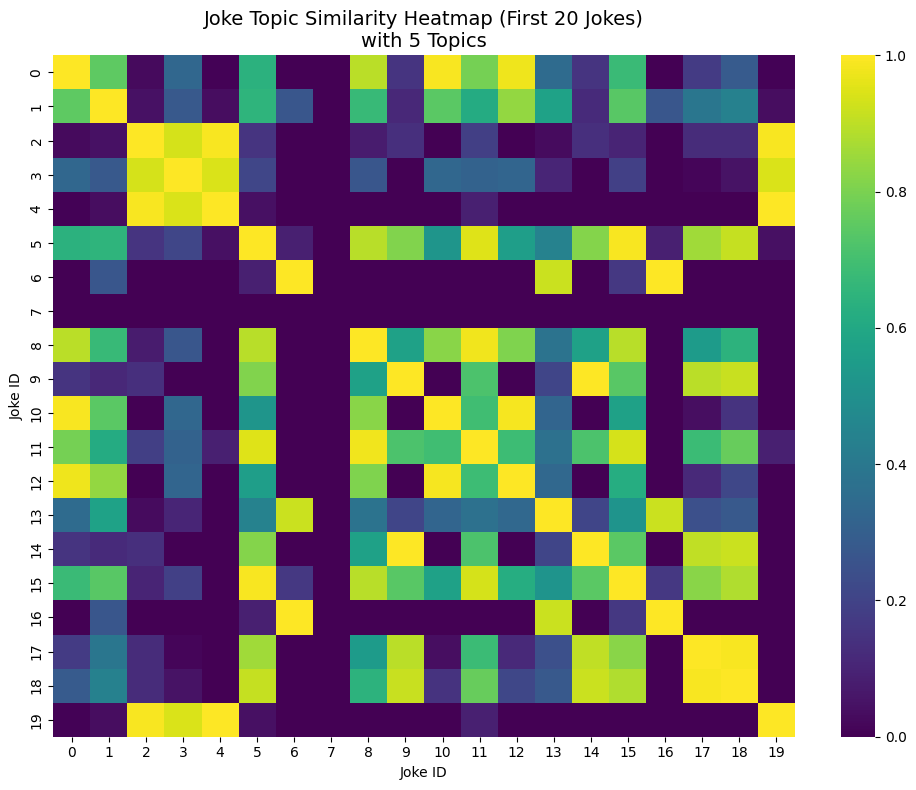

Topic diversity (mean std of joke-topic weights): 0.0975
Average joke similarity: 0.3415


In [97]:
# Compare with 10 topics
nmf_10, W_10, sim_10, topics_10 = compare_joke_similarities(tfidf, jokes_df, n_topics=10)

# Compare with 20 topics  
nmf_20, W_20, sim_20, topics_20 = compare_joke_similarities(tfidf, jokes_df, n_topics=20)

# Compare with 5 topics
nmf_5, W_5, sim_5, topics_5 = compare_joke_similarities(tfidf, jokes_df, n_topics=5)

#### Note - Number of topics chosen - 10 
- With more topics, the less commonality between jokes that can be found. 
- With less topics, there are more jokes that are similar to each other. 

#### Unlike LLM, NMF is unable to capture underlining contextual meaning of the jokes
- We might want to use a slightly higher number of topics, without running out of similar jokes
- Will choose 10 topics for now

#####  Exploring the Topics
Let's examine what words are most important for each topic:

In [62]:
# Get the most important words for each topic
def display_topics(model, feature_names, n_top_words=10):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words-1:-1]
        topic_words[topic_idx] = [feature_names[i] for i in top_indices]
    return topic_words

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display top 10 words for each topic
topic_words = display_topics(nmf, feature_names, 10)

for topic_idx, words in topic_words.items():
    print(f"Topic #{topic_idx}: {', '.join(words)}")


Topic #0: say, walk, make, long, hillary, bar, bartender, reply, asks, great
Topic #1: difference, whats, president, know, lawyer, dont, great, use, clinton, long
Topic #2: engineer, said, mechanical, company, look, end, year, machine, problem, time
Topic #3: bulb, light, screw, thats, change, president, lightbulb, day, father, problem
Topic #4: man, woman, doctor, asked, know, news, guy, husband, drink, room



#### User-to-User Similarity Matrix with Cosine Similarity
create a user-to-user similarity matrix based on their joke ratings

In [ ]:
def create_user_similarity_matrix(ratings_df):
    """
    Create a user-to-user similarity matrix using cosine similarity based on joke ratings.
    
    Parameters:
    -----------
    ratings_df : pandas.DataFrame
        DataFrame with columns ['UserID', 'JokeId', 'Rating']
    
    Returns:
    --------
    tuple
        (user_similarity_matrix, user_to_idx_mapping, idx_to_user_mapping)
    """
    print("Creating user similarity matrix...")
    
    # Create mappings for user and joke IDs
    unique_users = ratings_df['UserID'].unique()
    unique_jokes = ratings_df['JokeId'].unique()
    
    print(f"Number of users: {len(unique_users)}")
    print(f"Number of jokes: {len(unique_jokes)}")
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    joke_to_idx = {joke: idx for idx, joke in enumerate(unique_jokes)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    
    # Create sparse matrix (users × jokes)
    rows, cols, data = [], [], []
    for _, row in ratings_df.iterrows():
        user_idx = user_to_idx[row['UserID']]
        joke_idx = joke_to_idx[row['JokeId']]
        rows.append(user_idx)
        cols.append(joke_idx)
        data.append(row['Rating'])
    
    # Create sparse user-joke matrix
    n_users = len(unique_users)
    n_jokes = len(unique_jokes)
    user_joke_matrix = csr_matrix((data, (rows, cols)), shape=(n_users, n_jokes))
    
    print("Computing cosine similarities...")
    
    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_joke_matrix)
    
    print(f"User similarity matrix shape: {user_similarity.shape}")    
    return user_similarity, user_to_idx, idx_to_user

In [260]:
user_similarity, user_to_idx, idx_to_user = create_user_similarity_matrix(train_user_rating_df)

Creating user similarity matrix...
Number of users: 36710
Number of jokes: 100
Computing cosine similarities...
User similarity matrix shape: (36710, 36710)


In [261]:
# Check the shape of the user similarity matrix
print(f"User similarity matrix shape: {user_similarity.shape}")
# Check the first 5 rows and columns of the user similarity matrix
print("User similarity matrix (first 5 rows and columns):")
print(user_similarity[:5, :5])
# Check the first 5 users and their similarity scores
for i in range(5):
    print(f"User {idx_to_user[i]} similarity scores: {user_similarity[i, :5]}")

User similarity matrix shape: (36710, 36710)
User similarity matrix (first 5 rows and columns):
[[ 1.         -0.16951129  0.0920009   0.24133247  0.36998924]
 [-0.16951129  1.         -0.18724276  0.03312991 -0.08008281]
 [ 0.0920009  -0.18724276  1.          0.02270996  0.30826777]
 [ 0.24133247  0.03312991  0.02270996  1.          0.25929823]
 [ 0.36998924 -0.08008281  0.30826777  0.25929823  1.        ]]
User User1 similarity scores: [ 1.         -0.16951129  0.0920009   0.24133247  0.36998924]
User User10 similarity scores: [-0.16951129  1.         -0.18724276  0.03312991 -0.08008281]
User User100 similarity scores: [ 0.0920009  -0.18724276  1.          0.02270996  0.30826777]
User User1000 similarity scores: [0.24133247 0.03312991 0.02270996 1.         0.25929823]
User User10000 similarity scores: [ 0.36998924 -0.08008281  0.30826777  0.25929823  1.        ]


In [262]:
# Helper function to find similar users
def find_similar_users(user_id, user_similarity, user_to_idx, idx_to_user, n=5):
    """
    Find the top N users most similar to the given user_id.
    
    Parameters:
    -----------
    user_id : str
        The UserID to find similar users for
    user_similarity : numpy.ndarray
        User similarity matrix
    user_to_idx : dict
        Mapping from UserID to matrix index
    idx_to_user : dict
        Mapping from matrix index to UserID
    n : int
        Number of similar users to return
    
    Returns:
    --------
    list
        List of (UserID, similarity_score) tuples
    """
    if user_id not in user_to_idx:
        return []
    
    # Get the user's index in the similarity matrix
    user_idx = user_to_idx[user_id]
    
    # Get similarity scores for this user with all other users
    sim_scores = user_similarity[user_idx]
    
    # Create a list of (index, similarity) tuples, excluding the user itself
    user_sims = [(idx, score) for idx, score in enumerate(sim_scores) if idx != user_idx]
    
    # Sort by similarity score in descending order
    user_sims.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top N users
    top_users = user_sims[:n]
    
    # Convert indices back to UserIDs
    result = [(idx_to_user[idx], score) for idx, score in top_users]
    
    return result

In [272]:
# test the function with a specific user
top_10_similar_users = find_similar_users('User36704', user_similarity, user_to_idx, idx_to_user, n=10)
print("Top 10 similar users to User36704:")
for user, score in top_10_similar_users:
    print(f"User: {user}, Similarity Score: {score:.4f}")

Top 10 similar users to User36704:
User: User36583, Similarity Score: 0.6401
User: User36404, Similarity Score: 0.6119
User: User35928, Similarity Score: 0.5961
User: User36095, Similarity Score: 0.5869
User: User31076, Similarity Score: 0.5861
User: User36658, Similarity Score: 0.5855
User: User36416, Similarity Score: 0.5822
User: User35800, Similarity Score: 0.5751
User: User35057, Similarity Score: 0.5719
User: User35944, Similarity Score: 0.5657


#### Recommendation System

- Baseline approach
    - predict the test rating by user's avg from the train set 
- Content similarity approach 
-  User to User Collaborative approach
- Apply Predict function to compare the 4 approaches 

In [101]:
# Get user average rating from the training set
user_avg_rating = train_user_rating_df.groupby('UserID')['Rating'].mean().reset_index()
user_avg_rating.columns = ['UserID', 'AvgRating']


----- Topics with n_topics=20 -----
Topic #0: say, great, beer, ill, voice, make, positive, youre, look, reply
Topic #1: difference, whats, dont, lawyer, use, great, know, work, year, long
Topic #2: engineer, mechanical, look, said, machine, end, company, problem, ill, car
Topic #3: bulb, light, screw, thats, change, day, father, president, boy, beer
Topic #4: woman, man, need, want, guy, car, drink, know, got, age
Topic #5: walk, bar, bartender, guy, drink, order, got, long, reply, asks
Topic #6: lightbulb, change, problem, drink, thats, room, told, day, bulb, machine
Topic #7: husband, year, later, married, ill, tell, woman, teller, wife, hillary
Topic #8: clinton, tell, know, difference, hillary, return, got, reply, dollar, pope
Topic #9: school, teacher, mother, come, boy, want, got, tell, son, dont
Topic #10: asked, going, yes, replied, theyre, order, tell, girl, told, broom
Topic #11: make, pope, told, lawyer, left, negative, language, dollar, hillary, positive
Topic #12: like, 

/Users/squ/.pyenv/versions/3.12.9/envs/devenv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


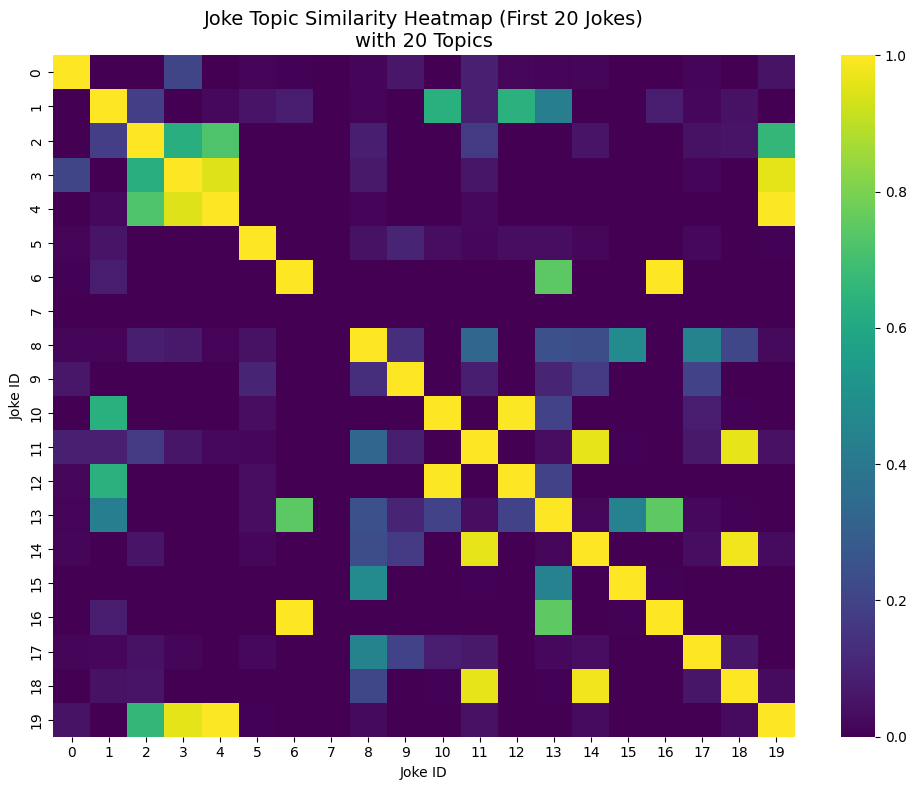

Topic diversity (mean std of joke-topic weights): 0.0790
Average joke similarity: 0.0914


In [242]:
#  Use cosine similarity via NMF using 10topics between jokes to rate the jokes based on rating for similar jokes for that user
nmf, W, joke_similarities, topic_words = compare_joke_similarities(tfidf, jokes_df, n_topics=20)

In [243]:
print(joke_similarities)

[[1.00000000e+00 7.10931062e-05 5.19863006e-04 ... 0.00000000e+00
  2.87518278e-03 1.78849826e-03]
 [7.10931062e-05 1.00000000e+00 1.81618956e-01 ... 0.00000000e+00
  2.59112491e-03 3.87457973e-04]
 [5.19863006e-04 1.81618956e-01 1.00000000e+00 ... 2.38017409e-04
  0.00000000e+00 5.22873631e-01]
 ...
 [0.00000000e+00 0.00000000e+00 2.38017409e-04 ... 1.00000000e+00
  0.00000000e+00 2.84457562e-04]
 [2.87518278e-03 2.59112491e-03 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 6.02979826e-01]
 [1.78849826e-03 3.87457973e-04 5.22873631e-01 ... 2.84457562e-04
  6.02979826e-01 1.00000000e+00]]


In [265]:
def content_based_prediction(user_id, joke_similarities, user_avg_rating, jokes_df, train_df=None, n=5):
	"""
	Predict ratings for a user based on content-based filtering using NMF topic modeling.
	Fixed version that properly maps joke IDs to indices in the similarity matrix.
	"""
	if train_df is None:
		train_df = train_user_rating_df
	
	user_id = str(user_id)  # Ensure user_id is a string
	
	# Get the user's average rating
	if user_id in user_avg_rating['UserID'].values:
		user_avg = user_avg_rating[user_avg_rating['UserID'] == user_id]['AvgRating'].values[0]
	else:
		user_avg = user_avg_rating['AvgRating'].mean()  # Use global average
	
	# Get jokes rated by this user in the training set
	user_rated_jokes = train_df[train_df['UserID'] == user_id][['JokeId', 'Rating']]
	
	if len(user_rated_jokes) == 0:
		# No training data for this user, return empty DataFrame
		return pd.DataFrame(columns=['JokeId', 'PredictedRating', 'JokeText'])
	
	# Create a mapping from JokeId to index in the similarity matrix
	# The matrix indices correspond to the position in jokes_df
	joke_id_to_index = {joke_id: idx for idx, joke_id in enumerate(jokes_df['JokeId'])}
	
	# Calculate predicted ratings for each rated joke (for demonstration)
	predictions = {}
	
	for _, row in user_rated_jokes.iterrows():
		joke_id = row['JokeId']
		actual_rating = row['Rating']
		
		# Get other jokes rated by this user
		other_ratings = user_rated_jokes[user_rated_jokes['JokeId'] != joke_id]
		
		if len(other_ratings) == 0:
			predictions[joke_id] = user_avg
			continue
			
		# Convert joke_id to index in similarity matrix
		if joke_id not in joke_id_to_index:
			print(f"Warning: JokeId {joke_id} not found in jokes_df")
			predictions[joke_id] = user_avg
			continue
			
		joke_idx = joke_id_to_index[joke_id]
		sim_scores = joke_similarities[joke_idx]
		
		total_sim = 0
		weighted_sum = 0
		
		# Calculate weighted average of ratings based on joke similarity
		for _, other_row in other_ratings.iterrows():
			other_joke_id = other_row['JokeId']
			other_rating = other_row['Rating']
			
			# Convert other_joke_id to index
			if other_joke_id not in joke_id_to_index:
				continue
				
			other_joke_idx = joke_id_to_index[other_joke_id]
			similarity = sim_scores[other_joke_idx]
			# print(f"JokeId: {joke_id}, Other JokeId: {other_joke_id}, Similarity: {similarity}")
			
			# Only use positive similarities
			if similarity > 0:
				weighted_sum += similarity * other_rating
				total_sim += similarity
				# print('weighted_sum:', weighted_sum)
				# print('total_sim:', total_sim)
				# print('similarity:', similarity)
		
		# Calculate the prediction
		if total_sim > 0:
			predictions[joke_id] = weighted_sum / total_sim
		else:
			predictions[joke_id] = user_avg
			
		# print(f"Predicted Rating for JokeId {joke_id}: {predictions[joke_id]:.2f} (actual: {actual_rating:.2f})")
	
	# Create a DataFrame with predicted ratings and corresponding joke texts
	if predictions:
		pred_df = pd.DataFrame({
			'JokeId': list(predictions.keys()),
			'PredictedRating': list(predictions.values())
		})
		
		pred_df = pred_df.merge(jokes_df[['JokeId', 'JokeText']], on='JokeId')
		return pred_df
	else:
		return pd.DataFrame(columns=['JokeId', 'PredictedRating', 'JokeText'])

In [245]:
# test 
content_based_prediction('User36706', joke_similarities, user_avg_rating, jokes_df, train_user_rating_df, n=5)


,JokeId,PredictedRating,JokeText
0,11.0,-1.002778,A guy stood over his tee shot for what seemed ...
1,33.0,-2.549006,"Out in the backwoods of some midwestern state,..."
2,9.0,3.537533,"Two cannibals are eating a clown, one turns to..."
3,46.0,0.464944,There was an engineer who had an exceptional g...
4,6.0,4.388719,How many feminists does it take to screw in a ...
5,49.0,1.304808,A guy goes into confession and says to the pri...
6,30.0,4.651877,President Clinton looks up from his desk in t...
7,61.0,2.122778,A group of managers were given the assignment...
8,45.0,2.515915,A couple has been married for 75 years. For th...
9,68.0,0.950055,"This guys wife asks, ""Honey if I died would yo..."


In [290]:
# create a generic function that predicts ratings in the test set
def predict_ratings(test_df, approach='user_avg', **kwargs):
    """
    Predict ratings for test data using various approaches.
    
    Parameters:
    -----------
    test_df : pandas.DataFrame
        Test data containing columns ['UserID', 'JokeId', 'Rating']
    approach : str
        Prediction approach to use:
        - 'user_avg': Use user's average rating from training data
        - 'content_sim': Use content-based similarity
        - 'user_user_sim': Use user-to-user collaborative filtering
        - 'collab_filter': Use collaborative filtering
    **kwargs : dict
        Additional arguments for specific approaches
    
    Returns:
    --------
    pandas.DataFrame
        Test data with added 'Prediction' column
    """
    # Create a copy of the test DataFrame to avoid modifying the original
    result_df = test_df.copy()
    
    if approach == 'user_avg':
        # User average approach requires user_avg_df parameter
        if 'user_avg_df' not in kwargs:
            raise ValueError("user_avg_df is required for user_avg approach")
        user_avg_df = kwargs['user_avg_df']
        
        # Merge with user averages
        result_df = result_df.merge(user_avg_df, on='UserID', how='left')
        
        # For users not in the training set, use the global average
        global_avg = user_avg_df['AvgRating'].mean()
        print(f"Global average rating: {global_avg:.2f}")
        # Fill NaN values with global average
        result_df['Prediction'] = result_df['AvgRating'].fillna(global_avg)
        
        # Drop the merged column to keep the DataFrame clean
        result_df = result_df.drop('AvgRating', axis=1)
        
    elif approach == 'content_sim':
        if 'joke_similarities' not in kwargs or 'jokes_df' not in kwargs:
            raise ValueError("joke_similarities and jokes_df are required for content_sim approach")
        
        joke_similarities = kwargs['joke_similarities']
        jokes_df = kwargs['jokes_df']
        train_df = kwargs.get('train_df', train_user_rating_df)
        num_similar_jokes = kwargs.get('num_similar_jokes', 5)
        
        print("Starting content-based prediction...")
        
        # Create joke ID to index mapping
        joke_id_to_index = {joke_id: idx for idx, joke_id in enumerate(jokes_df['JokeId'])}
        
        # Initialize predictions column
        result_df['Prediction'] = None
        
        # Convert training data to a sparse matrix for faster lookup
        # Create mappings for user and joke IDs
        unique_users = train_df['UserID'].unique()
        user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
        
        # Create CSR matrix of training ratings
        n_users = len(unique_users)
        n_jokes = len(joke_id_to_index)
        
        # Create row, col, data arrays for sparse matrix construction
        rows, cols, data = [], [], []
        for _, row in train_df.iterrows():
            user_idx = user_to_idx.get(row['UserID'])
            joke_idx = joke_id_to_index.get(row['JokeId'])
            if user_idx is not None and joke_idx is not None:
                rows.append(user_idx)
                cols.append(joke_idx)
                data.append(row['Rating'])
        
        # Create sparse rating matrix
        ratings_matrix = csr_matrix((data, (rows, cols)), shape=(n_users, n_jokes))
        
        # Process by user for efficiency
        user_count = 0
        for user_id, group in result_df.groupby('UserID'):
            user_count += 1
            if user_count % 100 == 0:
                print(f"Processing user {user_count}/{len(result_df['UserID'].unique())}")
                
            # Get user index
            user_idx = user_to_idx.get(user_id)
            
            # If user not in training set, use the global average
            if user_idx is None:
                global_avg = train_df['Rating'].mean()
                result_df.loc[group.index, 'Prediction'] = global_avg
                continue
            
            # Process each joke in this user's test set
            for idx, row in group.iterrows():
                joke_id = row['JokeId']
                
                # Get joke index
                if joke_id not in joke_id_to_index:
                    # If joke not in mapping, use user average
                    user_avg = train_df[train_df['UserID'] == user_id]['Rating'].mean()
                    result_df.loc[idx, 'Prediction'] = user_avg
                    continue
                
                joke_idx = joke_id_to_index[joke_id]
                
                # Get similarity scores with all jokes
                sim_scores = joke_similarities[joke_idx]
                
                # Find top 5 most similar jokes that this user has rated
                # Get indices of jokes this user has rated
                user_rated_indices = ratings_matrix[user_idx].nonzero()[1]
                
                if len(user_rated_indices) == 0:
                    # If user hasn't rated any jokes, use global average
                    result_df.loc[idx, 'Prediction'] = train_df['Rating'].mean()
                    continue
                
                # Get similarities for jokes this user has rated
                rated_similarities = sim_scores[user_rated_indices]
                
                # Sort by similarity and get top num_similar_jokes
                top_indices = np.argsort(-rated_similarities)[:num_similar_jokes]  # Minus for descending order
                
                # Get the actual joke indices
                top_joke_indices = user_rated_indices[top_indices]
                
                # If we don't have any similar jokes, use user average
                if len(top_joke_indices) > 0:
                    # Get ratings from the user's sparse rating vector
                    user_ratings = ratings_matrix[user_idx].toarray().flatten()
                    top_ratings = user_ratings[top_joke_indices]
                    
                    # Simple average of top num_similar_jokes similar joke ratings
                    prediction = np.mean(top_ratings)

                    # Weighted average based on similarity - not used
                    # weighted_sum = np.sum(rated_similarities[top_indices] * top_ratings)
                    # total_sim = np.sum(rated_similarities[top_indices])
                    
                    #prediction = weighted_sum / total_sim if total_sim > 0 else train_df[train_df['UserID'] == user_id]['Rating'].mean()
                    
                    # Clip to valid range
                    prediction = max(min(prediction, 10), -10)
                    # print(f"Predicted Rating for User {user_id}, JokeId {joke_id}: {prediction:.2f}")
                    
                else:
                    # No similar jokes, use user average
                    prediction = train_df[train_df['UserID'] == user_id]['Rating'].mean()
                
                result_df.loc[idx, 'Prediction'] = prediction
        
    elif approach == 'user_user_cf':
        # User-to-user collaborative filtering approach
        if ('user_similarity' not in kwargs or 
            'user_to_idx' not in kwargs or 
            'idx_to_user' not in kwargs):
            raise ValueError("user_similarity, user_to_idx, and idx_to_user are required for user_user_cf approach")
        
        start_time = time.time()
        print("Starting user-based collaborative filtering prediction...")
        
        # Get parameters
        user_similarity = kwargs['user_similarity']
        user_to_idx = kwargs['user_to_idx']
        idx_to_user = kwargs['idx_to_user']
        train_df = kwargs.get('train_df', train_user_rating_df)
        n_neighbors = kwargs.get('n_neighbors', 10)
        weighted = kwargs.get('weighted', False) 
        
        # Initialize predictions column
        result_df['Prediction'] = None
        
        # Create a lookup dictionary for user ratings
        user_joke_ratings = {}
        for _, row in train_df.iterrows():
            user_id = row['UserID']
            joke_id = row['JokeId']
            rating = row['Rating']
            
            if user_id not in user_joke_ratings:
                user_joke_ratings[user_id] = {}
                
            user_joke_ratings[user_id][joke_id] = rating
            
        # Get global average for fallback
        global_avg = train_df['Rating'].mean()
        print(f"Global average rating: {global_avg:.2f}")
        
        # Process each test row
        user_count = 0
        total_users = len(result_df['UserID'].unique())
        
        for user_id, group in result_df.groupby('UserID'):
            user_count += 1
            if user_count % 100 == 0 or user_count == total_users:
                print(f"Processing user {user_count}/{total_users} ({time.time() - start_time:.2f}s elapsed)")
                
            # Skip if user not in training set
            if user_id not in user_to_idx:
                result_df.loc[group.index, 'Prediction'] = global_avg
                continue
                
            # Find similar users
            user_idx = user_to_idx[user_id]
            sim_scores = user_similarity[user_idx]
            
            # Create a list of (user_id, similarity) tuples, excluding the user itself
            user_sims = [(idx_to_user[idx], score) for idx, score in enumerate(sim_scores) 
                         if idx != user_idx and score > 0]  # Only consider positive similarities
            
            # Sort by similarity score in descending order and get top n_neighbors
            user_sims.sort(key=lambda x: x[1], reverse=True)
            top_similar_users = user_sims[:n_neighbors]
            
            if not top_similar_users:
                # If no similar users found, use user average or global average
                user_ratings = train_df[train_df['UserID'] == user_id]['Rating']
                if len(user_ratings) > 0:
                    user_avg = user_ratings.mean()
                    result_df.loc[group.index, 'Prediction'] = user_avg
                else:
                    result_df.loc[group.index, 'Prediction'] = global_avg
                continue
            
            # Process each joke for this user
            for idx, row in group.iterrows():
                joke_id = row['JokeId']
                
                # Find users who rated this joke
                users_who_rated = []
                for sim_user_id, sim_score in top_similar_users:
                    if sim_user_id in user_joke_ratings and joke_id in user_joke_ratings[sim_user_id]:
                        users_who_rated.append((sim_user_id, sim_score, user_joke_ratings[sim_user_id][joke_id]))
                
                if not users_who_rated:
                    # If no similar users rated this joke, use user's average rating
                    user_avg = train_df[train_df['UserID'] == user_id]['Rating'].mean()
                    result_df.loc[idx, 'Prediction'] = user_avg
                    continue
                
                if weighted:
                    # Weighted average approach
                    weighted_sum = 0
                    similarity_sum = 0
                    
                    for _, sim_score, rating in users_who_rated:
                        weighted_sum += sim_score * rating
                        similarity_sum += sim_score
                    
                    if similarity_sum > 0:
                        prediction = weighted_sum / similarity_sum
                    else:
                        prediction = global_avg
                else:
                    # Simple average approach
                    prediction = np.mean([rating for _, _, rating in users_who_rated])
                
                # Clip prediction to valid range
                prediction = max(min(prediction, 10), -10)
                result_df.loc[idx, 'Prediction'] = prediction        
        
        print(f"User-based collaborative filtering completed in {time.time() - start_time:.2f}s")

    else:
        raise ValueError(f"Unknown approach: {approach}")
        
    return result_df


In [239]:
def evaluate_predictions(predictions_df):
    """
    Evaluate predictions using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
    
    Parameters:
    -----------
    predictions_df : pandas.DataFrame
        DataFrame containing 'Rating' and 'Prediction' columns
    
    Returns:
    --------
    tuple
        (MAE, RMSE)
    """
    # Calculate errors
    predictions_df['Error'] = predictions_df['Rating'] - predictions_df['Prediction']
    
    # Calculate metrics
    mae = predictions_df['Error'].abs().mean()
    rmse = np.sqrt((predictions_df['Error'] ** 2).mean())
    
    return mae, rmse

In [240]:
# RMSE and MAE for user average
user_avg_predictions = predict_ratings(test_user_rating_df, 
                                       approach='user_avg', 
                                       user_avg_df=user_avg_rating)
user_avg_mae, user_avg_rmse = evaluate_predictions(user_avg_predictions)
print(f"User Average Approach - MAE: {user_avg_mae:.4f}, RMSE: {user_avg_rmse:.4f}")

Global average rating: 0.68
User Average Approach - MAE: 3.7187, RMSE: 4.6274


In [250]:
# RMSE and MAE for content similarity
content_sim_predictions = predict_ratings(test_user_rating_df, 
                                          approach='content_sim', 
                                          joke_similarities=joke_similarities, 
                                          jokes_df=jokes_df,
                                          user_avg_df=user_avg_rating,
                                          num_similar_jokes=20)


Starting content-based prediction...
Processing user 100/36710
Processing user 200/36710
Processing user 300/36710
Processing user 400/36710
Processing user 500/36710
Processing user 600/36710
Processing user 700/36710
Processing user 800/36710
Processing user 900/36710
Processing user 1000/36710
Processing user 1100/36710
Processing user 1200/36710
Processing user 1300/36710
Processing user 1400/36710
Processing user 1500/36710
Processing user 1600/36710
Processing user 1700/36710
Processing user 1800/36710
Processing user 1900/36710
Processing user 2000/36710
Processing user 2100/36710
Processing user 2200/36710
Processing user 2300/36710
Processing user 2400/36710
Processing user 2500/36710
Processing user 2600/36710
Processing user 2700/36710
Processing user 2800/36710
Processing user 2900/36710
Processing user 3000/36710
Processing user 3100/36710
Processing user 3200/36710
Processing user 3300/36710
Processing user 3400/36710
Processing user 3500/36710
Processing user 3600/36710


In [251]:
content_sim_mae, content_sim_rmse = evaluate_predictions(content_sim_predictions)
print(f"Content Similarity Approach - MAE: {content_sim_mae:.4f}, RMSE: {content_sim_rmse:.4f}")

Content Similarity Approach - MAE: 3.7061, RMSE: 4.6765


In [288]:
# number of users to use from test set
num_users_subset = 300

# Get the first x unique users from the test set
first_x_users = test_user_rating_df['UserID'].unique()[:num_users_subset]

# Create a subset of the test data with only these users
user_test_subset = test_user_rating_df[test_user_rating_df['UserID'].isin(first_x_users)].copy()


# RMSE and MAE for user to user collaborative filter 
user_user_cf_predictions = predict_ratings(user_test_subset, 
                                          approach='user_user_cf', 
                                          user_similarity=user_similarity,
                                          user_to_idx=user_to_idx,
                                          idx_to_user=idx_to_user,
                                          train_df=train_user_rating_df,
                                          n_neighbors=5
                                        )

Starting user-based collaborative filtering prediction...
Global average rating: 0.72
Processing user 100/300 (119.78s elapsed)
Processing user 200/300 (215.48s elapsed)
Processing user 300/300 (309.87s elapsed)
User-based collaborative filtering completed in 310.91s


In [289]:
# Calculate metrics on the subset
subset_mae, subset_rmse = evaluate_predictions(user_user_cf_predictions)
print(f"User-User CF (100 users) - MAE: {subset_mae:.4f}, RMSE: {subset_rmse:.4f}")

User-User CF (100 users) - MAE: 3.8482, RMSE: 4.8215


#### Summary of methods and performance
|Method|RMSE|
|:----|:--------:|
|Baseline, $Y_p=\mu_u$| 4.6274 |
|Content based, item-item NMF 10 topics, top 5 sim avg | 4.9823 |
|Content based, item-item NMF 10 topics, top 5 sim weighted avg | 4.9709 |
|Content based, item-item NMF 10 topics, top 20 sim avg | 4.6874 |
|Content based, item-item NMF 10 topics, top 20 sim weighted avg | 4.7112 |
|Content based, item-item NMF 20 topics, top 20 sim avg | 4.6765 |
|Collaborative filtering, user-user, cosine sim, avg rating of top 10 sim users (300 test user subset) | 4.8290 |
|Collaborative filtering, user-user, cosine sim, avg rating of top 50 sim users (300 test user subset)| 4.9193 |
|Collaborative filtering, user-user, cosine sim, avg rating of top 5 sim users (300 test user subset)| 4.8215 |

#### Analysis of the Recommender - Why Content Based or User Based Collaborative Filtering Underperforms the User Average Baseline

1. Rating Scale Subjectivity
Users rate jokes on their own subjective scales - one person's "7" might be another person's "5" for the same level of enjoyment. The baseline accounts for this by simply learning each user's average rating tendency, which can be a powerful signal.

2. Limited Content Signal from NMF
The joke topic modeling using NMF might not be capturing the true elements that make jokes similar in terms of user preferences. Humor is highly contextual and often relies on subtle linguistic features that simple topic models miss.

3. Preference Consistency
For jokes, a user's average rating is often a strong predictor because people tend to have fairly consistent reactions to humor. The baseline captures this pattern directly.

#### Possible Improvements Ideas

- Try normalizing ratings by user means before similarity calculations

- Try embedding-based approaches for better joke representation, such as using BertTopic. It would better capture the semantic meaning the jokes. 
